In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets.widgets import Button, Box
from IPython import display

%matplotlib inline

**Problem Description**

Everybody has to be assigned to exactly one timeslot; we know which ones they're available for and which ones they prefer. Try to maximize the number of people assigned to timeslots they prefer while keeping the number of students at each time similar.

**Notes**

Currently, this fails if you can't move anybody from the most populated time to the least populated time. This shouldn't be too hard to fix by moving somebody either from the second-most populated time to the least populated time or from the most populated time to the second least populated time.

In [2]:
def synthetic_data(n_students=50, n_students_no_answer=10, n_timeslots=3):
    students = []
    names = []
    for _ in range(n_students):
        first_name = ''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyzaaeeiioouusst'), size=7))
        last_name = ''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyzaaeeiioouusst'), size=6))
        availability = np.random.choice(['No', 'Yes', 'Yes'], size=n_timeslots)
        preference = np.random.choice(np.arange(n_timeslots))
        availability[preference] = 'Yes' # make sure you're available during your preferred time!
        students.append([first_name, last_name, *availability, preference])
        names.append([last_name, first_name])
    pd.DataFrame(students).to_csv('responses.csv', index=None, header=None)
    
    for _ in range(n_students_no_answer):
        first_name = ''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyzaaeeiioouusst'), size=7))
        last_name = ''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyzaaeeiioouusst'), size=6))
        names.append([last_name, first_name])
    pd.DataFrame(names).to_csv('names.csv', index=None, header=None)

In [3]:
# synthetic_data()

In [4]:
students = pd.read_csv('responses.csv', header=None)

n_timeslots = students.shape[1] - 3

students.columns = ['first_name', 'last_name'] + [f'time_{i}' for i in range(n_timeslots)] + ['preference']
students = (students.assign(name=students.first_name + ' ' + students.last_name)
        .assign(assignment=students.preference)
        .set_index('name'))

students.head()

,first_name,last_name,time_0,time_1,time_2,preference,assignment
name,,,,,,,
utyldtq utbsyj,utyldtq,utbsyj,Yes,Yes,Yes,2,2
vjioscz tkuzoo,vjioscz,tkuzoo,Yes,Yes,Yes,2,2
fxuyqss aekabx,fxuyqss,aekabx,Yes,Yes,No,1,1
tjaeuas adhriu,tjaeuas,adhriu,No,Yes,Yes,1,1
rcvaieo eateee,rcvaieo,eateee,Yes,Yes,Yes,1,1


In [5]:
# for the students who didn't respond to the survey, just assign them to the classes that need more students

students_no_answer = (pd.read_csv('names.csv', header=None, names=['last_name', 'first_name'])
                        .assign(name=lambda df: df.first_name + ' ' + df.last_name)
                        .pipe(lambda df: df.loc[~df.name.isin(students.index)])
                        .assign(**{f'time_{i}': 'Yes' for i in range(n_timeslots)})
                        .set_index('name'))

assignments = []

class_counts = students.assignment.value_counts()
while len(assignments) < len(students_no_answer):
    least_populated_class = class_counts.idxmin()
    assignments.append(least_populated_class)
    class_counts.loc[least_populated_class] += 1

students_no_answer['assignment'] = assignments
students_no_answer['preference'] = assignments
students = pd.concat([students, students_no_answer]).sort_values('last_name').drop(['first_name', 'last_name'], axis=1)

n_students = len(students)
assert students.index.nunique() == len(students) # ensure that names are unique

In [6]:
students_reassigned = []

def plot():
    display.clear_output(wait=True)
    n_first_choice = (students.preference == students.assignment).sum()

    fig, ax = plt.subplots(ncols=2)

    pd.Series([n_first_choice, n_students - n_first_choice], index=['First Choice', 'Other']).plot.bar(ax=ax[0])
    students.assignment.value_counts().plot.bar(ax=ax[1])

def on_forward(x):
    # if there are ties, we just pick the first one
    class_counts = students.assignment.value_counts()
    most_populated_class = class_counts.index[0]
    least_populated_class = class_counts.index[-1]
    
    if class_counts.loc[most_populated_class] - class_counts.loc[least_populated_class]  > 1:
        student_to_move = students[(students.assignment == most_populated_class) &
                                   (students[f'time_{least_populated_class}'] == 'Yes')]\
                                  .sample().index[0]
        students.loc[student_to_move, 'assignment'] = least_populated_class
        students_reassigned.append(student_to_move)
        plot()

def on_backward(x):
    if students_reassigned:
        student_reassigned = students_reassigned.pop()
        students.loc[student_reassigned, 'assignment'] = students.loc[student_reassigned, 'preference']
        plot()

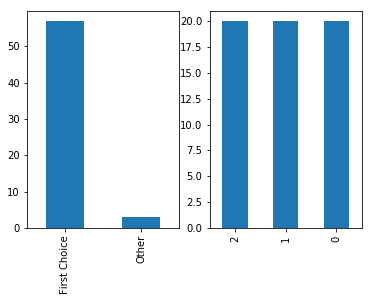

In [7]:
# use the right arrow to assign people from the most populated class to the least populated one
# use the left arrow to undo these assignments
# once you're happy with the balance between class size and number of people getting their first choice,
# move on to the next cell to save the data

forward = Button(icon='angle-right')
backward = Button(icon='angle-left')
buttons = Box([backward, forward])

forward.on_click(on_forward)
backward.on_click(on_backward)

plot()

buttons

In [8]:
# you can use this to get things in a nice format to export

assignment_dict = {
    0: '10 AM',
    1: '11 AM',
    2: '12 PM'
}

students = students.replace({'assignment': assignment_dict})
students.head()

,assignment,preference,time_0,time_1,time_2
name,,,,,
tjaeuas adhriu,11 AM,1,No,Yes,Yes
fxuyqss aekabx,11 AM,1,Yes,Yes,No
drineru aezfop,11 AM,1,Yes,Yes,Yes
geatuum agcpzx,10 AM,0,Yes,Yes,No
toajckn arcuht,11 AM,1,Yes,Yes,Yes


In [9]:
# if you want a csv
students.assignment.to_csv('assignments.csv', header=None)

In [10]:
! head assignments.csv

tjaeuas adhriu,11 AM
fxuyqss aekabx,11 AM
drineru aezfop,11 AM
geatuum agcpzx,10 AM
toajckn arcuht,11 AM
fzaytti arwjis,11 AM
eodiibj bhuvmo,11 AM
reuvscx casius,10 AM
kizbves ddmyht,10 AM
esesdqu dpoicr,10 AM
